+++
notebook = true
date = "2022-01-25"
title = "Mandel-Cryer Effect"
weight = 151
project = ["HydroMechanics/StaggeredScheme/MandelCryer/MandelCryerStaggered.prj"]
author = "Dominik Kern, Frieder Loer"
image = "./figures/MandelCryer_mesh.png"
web_subsection = "hydro-mechanics"
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./mandelcryer.ipynb" download="mandelcryer.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=mandelcryer.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/bilke/ogs/-/blob/web-versioning/Tests/Data/HydroMechanics/StaggeredScheme/MandelCryer/mandelcryer.py"><img src="https://img.shields.io/static/v1?label=Source:&message=mandelcryer.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/HydroMechanics/StaggeredScheme/MandelCryer/mandelcryer.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

## Mandel-Cryer Effect

This is a classical example to demonstrate the effect of hydromechanical coupling in a poroelastic medium.
For more details we refer to a textbook (Verruijt, 2009), in which also the analytical solution is derived.
As domain we consider a sphere, by symmetry we need to simulate only an octant.

![Domain Mesh](./figures/MandelCryer_mesh.png "Mesh")

The boundary conditions of hydraulics are atmospheric pressure on the sphere surface and impermeable elsewhere.
The boundary conditions of mechanics are an overburden (Neumann) applied as step load on the sphere surface at initial time $t=0$.
The remaining sides are fixed in normal direction (Dirichlet).

![Hydraulic and mechanics boundary conditions](./figures/MandelCryer_model.png "Boundary conditions")

The material is isotropic, linear elastic.
Solid and fluid are assumed to be incompressible.
In its initial state the sphere is not deformed and there is ambient pressure everywhere.
A sudden load increase on the surface is instantly transferred on the pore pressure, whereas the solid needs time to deform, until it carries the load.
Since the pore fluid is squeezed out of the outer layers first, they act like a tightening belt and consequently the pressure in the center rises, it may even exceed the value of the applied load.
Finally the pore pressure approaches to ambient pressure.

All parameters are concluded in the following tables.

### Material Properties

| Property                  | Value          | Unit         |
| ------------------------- | -------------- | ------------ |
| Fluid density             | $10^3$         | kg/m$^3$     |
| Viscosity                 | $10^{-3}$      | Pa$\cdot$s   |
| Porosity                  | $0.2$          | -            |
| Permeability              | $10\cdot 10^{-12}$ | m$^2$    |
| Young`s modulus (bulk)    | $10\cdot 10^6$ | Pa           |
| Poisson ratio (bulk)      | $0.1$          | -            |
| Biot coefficient          | $1.0$          | -            |
| Solid density             | $2.5\cdot 10^3$| kg/m$^3$     |
| Overburden                | $1000$         | Pa           |
| Atmospheric pressure      | $0$            | Pa           |

### Dimensions and Discretization

| Property                   | Value    | Unit                    |
| -------------------------- | -------- | ----------------------- |
| Radius                     | $0.4$    | m                       |
| Finite Elements            | $8741$   | Taylor-Hood tetrahedra  |
| Time step                  | $10^{-2}$| s                       |
| Coupling scheme parameter  | $0.7774$ | -                       |

## Numerical Simulation

   Due to the problem's symmetry, the benchmark is analyzed under axisymmetric conditions.


In [1]:
import os
from pathlib import Path

import ogstools as ot

In [2]:
# Create output path if it doesn't exist yet
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Initiate an OGS-object
# Pass it the project file and set an output file
model = ot.Project(
    input_file="MandelCryerStaggered.prj",
    output_file=f"{out_dir}/MandelCryerStaggered_modified.prj",
)

model.write_input()

# Run OGS
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/HydroMechanics/StaggeredScheme/MandelCryer/mandelcryer/MandelCryerStaggered_modified.prj
Status: finished successfully.
Execution took 20.486915111541748 s


## Results

In [4]:
# Load the result
ms = ot.MeshSeries(f"{out_dir}/results_MandelCryerStaggered.pvd")

Available point data in the results:

In [5]:
print(ms[0].point_data.keys())

['displacement', 'epsilon', 'pressure', 'sigma', 'velocity']


/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/.venv/lib/python3.13/site-packages/pyvista/core/utilities/points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


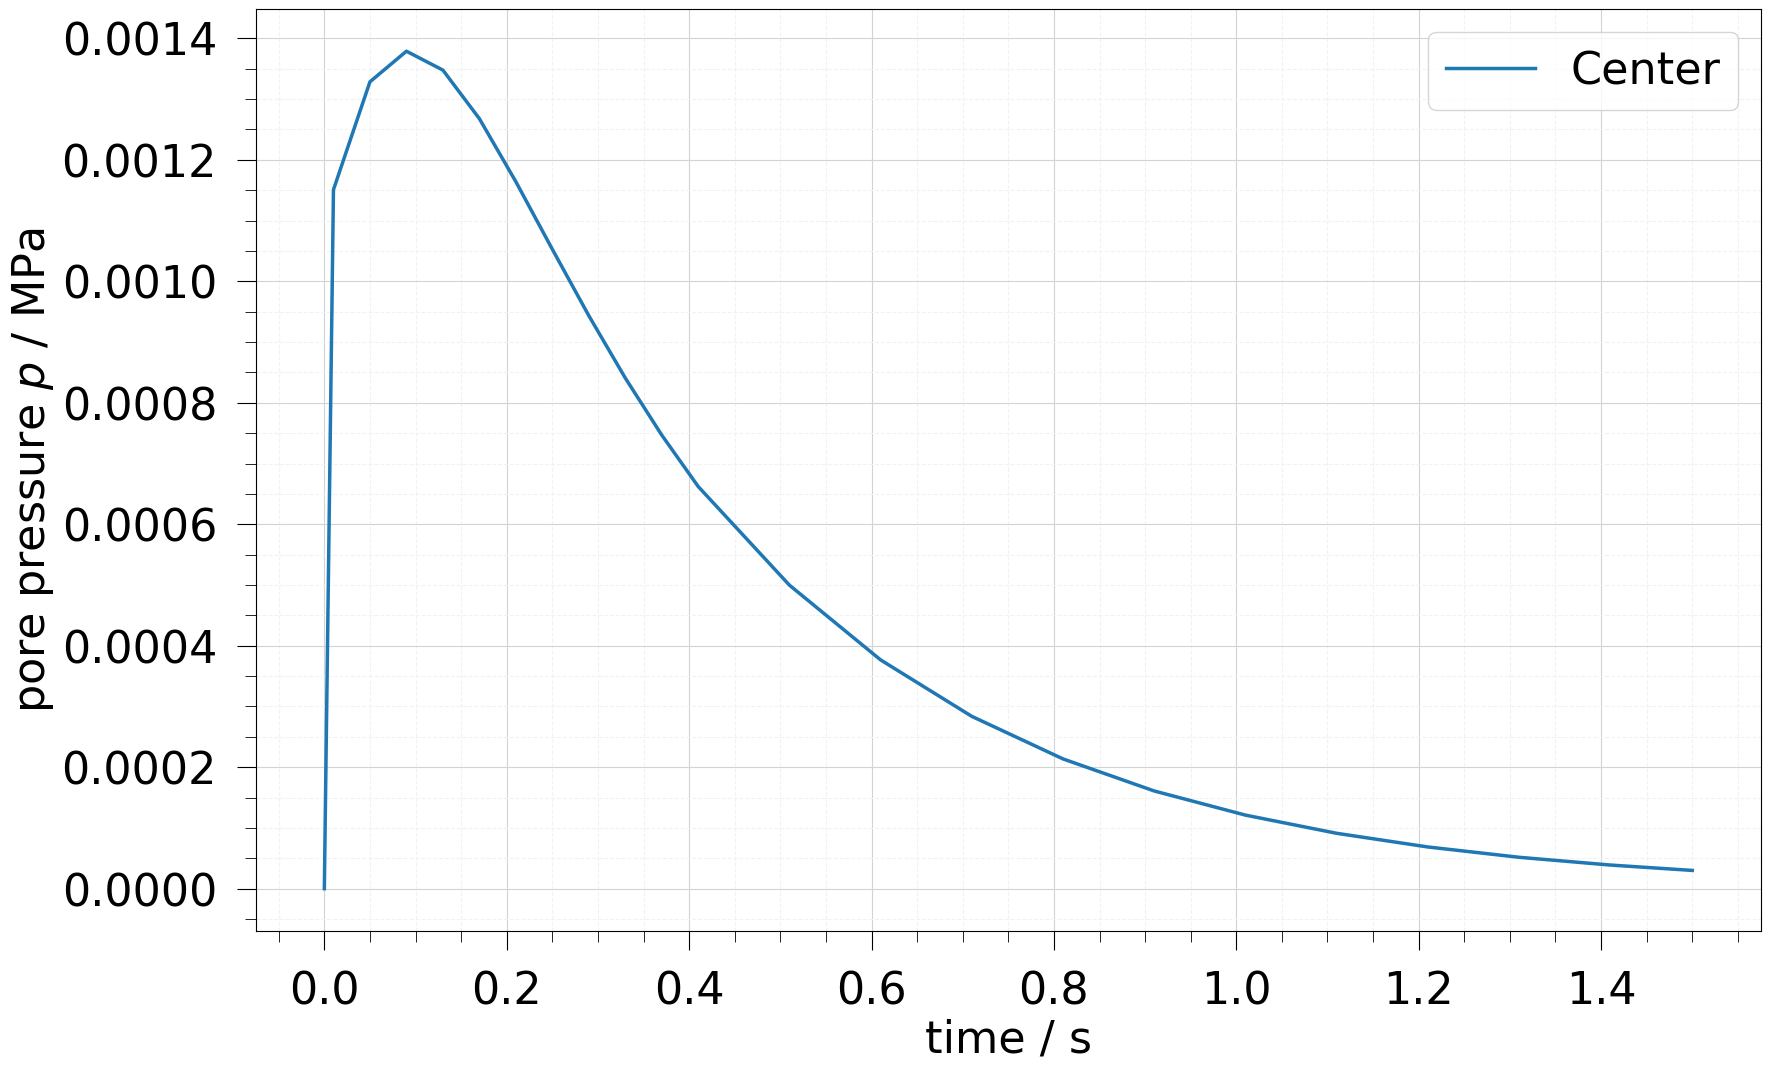

In [6]:
# Plot soil temperature at observation points
center_point = [0, 0, 0]
ms_pts = ot.MeshSeries.extract_probe(ms, center_point)
fig = ot.plot.line(ms_pts, "time", ot.variables.pressure, labels=["Center"])

As predicted, the pressure in the center exceeds the applied load and then levels out.

For more details about the staggered scheme we refer to the [user guide - conventions]({{< ref "conventions" >}}#staggered-scheme).

## References

[1] Verruijt, A. (2009): _An introduction to soil dynamics_. Springer Science and Business Media, DOI: <https://doi.org/10.1007/978-90-481-3441-0>, <https://link.springer.com/book/10.1007/978-90-481-3441-0>